# Data generation by volume

Generate additional RIRs with ```pyroomacoustics``` for a given volume; using monte-carlo techniques, generate a dataset of RIRs distributed over a variety of volumes 

In [1]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from numpy import random
from tqdm import tqdm
import os
import pandas as pd
import soundfile as sf

from IPython.display import Audio

In [2]:
sr = 44100

#define materials
m = pra.make_materials(
    ceiling="hard_surface",
    floor="carpet_soft_10mm",
    east="gypsum_board",
    west="gypsum_board",
    north="gypsum_board",
    south="gypsum_board",
)


In [3]:
def generate_room_dims(vol, var=.3):
    cube_length = np.power(vol, 1./3)
    side1, side2 = np.random.normal(loc=cube_length, scale=var*cube_length, size=2)
    side3 = vol/(side1*side2)
    return np.array([side1, side2, side3])

for _ in range(10):
    room_dims = generate_room_dims(1000)
    print(room_dims, room_dims[0]*room_dims[1]*room_dims[2])

[ 7.89429283 13.7828075   9.19071031] 1000.0
[ 7.24252746 11.13509114 12.39983977] 1000.0
[ 3.35623796 13.19631892 22.57846701] 1000.0
[13.03949429  9.28352299  8.2608823 ] 999.9999999999999
[11.30054905  8.18208344 10.81524971] 1000.0
[15.45423842  8.90567066  7.26583885] 1000.0
[12.23615296 10.61708469  7.69750218] 1000.0
[13.55567401 18.04532253  4.08803151] 1000.0
[12.09587843 14.69741755  5.6249874 ] 1000.0
[ 8.98799734 11.7824468   9.44281708] 1000.0000000000001


In [4]:
def generate_rirs(room_dims, n_mics, materials, sr=44100, max_order=10, loc_std=None):
    room_center = room_dims/2
    if loc_std is None:
        loc_std = np.average(room_dims)/3
    
    # Create the room
    room = pra.ShoeBox(
       room_dims, fs=sr, materials=materials, max_order=max_order,
       air_absorption=True, ray_tracing=True
    )
    
    source_loc = generate_in_room(room_center, room_dims, loc_std)
    try:
        room.add_source(source_loc)
    except Exception:
        print("{} in {} ".format(source_loc, room_dims))
    
    mic_locs = []
    for _ in range(n_mics):
        mic_locs.append(generate_in_room(room_center, room_dims, loc_std))
    room.add_microphone(np.array(mic_locs).T)

    room.compute_rir()
    rirs_out = []
    for i in range(n_mics):
        rirs_out.append(room.rir[i][0])
    return rirs_out

def generate_in_room(room_center, room_dims, loc_std, lim=100):
    loc = np.random.multivariate_normal(room_center, np.identity(3)*loc_std)
    count = 0
    while np.any(loc>room_dims) or np.any(loc<0):
        loc = np.random.multivariate_normal(room_center, np.identity(3)*loc_std)
        count += 1
        if count>lim:
            print("Limit {} reached, returning room center")
            loc = room_dims/2
            break
    return loc

    
    

In [5]:
rirs = generate_rirs(np.array([10,10,10]), 10, m)

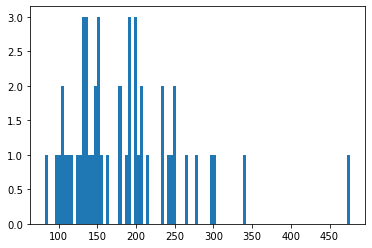

In [104]:
vol_data = np.random.lognormal(mean=np.log(150), sigma=.5, size=50)
_ = plt.hist(vol_data, bins=100)

In [105]:
rirs = []
room_dims = []
for vol in tqdm(vol_data):
    room_dim = generate_room_dims(vol, var=.3)
    room_dims.append(room_dim)
    rir = generate_rirs(room_dim, 1, m, max_order=50)
    rirs.append(rir[0])

100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


In [106]:
Audio(data=rirs[0], rate=sr)

In [107]:
Audio(data=rirs[25], rate=sr)

In [109]:
Audio(data=rirs[45], rate=sr)

In [113]:

#storing rirs
rir_dir = "/scratch/ci411/sonos_rirs/pra"
run_name = "0721_pra"

subdir = os.path.join(rir_dir, run_name)
labels = []
files = []
#os.mkdir(subdir)

for i, room_dim in enumerate(tqdm(room_dims)):
    label = run_name + "_room{}".format(i)
    labels.append(label)
    file = os.path.join(subdir, label+'.wav')
    sf.write(file, rirs[i], sr)
    files.append(file)



100%|██████████| 50/50 [00:01<00:00, 32.96it/s]


In [114]:
pra_df = pd.DataFrame(files, columns=['file'])
pra_df['vol'] = vol_data
pra_df['room'] = labels
pra_df['dataset'] = run_name

In [115]:
pra_df.to_csv(os.path.join(rir_dir, run_name+'_df.csv'))

In [5]:
#storing rirs
rir_dir = "/scratch/ci411/sonos_rirs/rirs/pra"
run_name = "080322_pra"

subdir = os.path.join(rir_dir, run_name)

if not os.path.exists(subdir):
    os.makedirs(subdir)
    
labels = []
files = []
#os.mkdir(subdir)

logvol_data = [1.3, 1.4, 1.76, 1.8, 1.82, 1.84,2.05, 2.1, 2.14, 2.19,2.2, 2.23,\
            2.3, 2.31, 2.39, 2.4, 2.43, 2.5, 2.53, 2.55, 2.6, 2.65, 2.7, 2.72,\
            2.75, 2.8, 2.87, 2.9, 3.1, 3.2]

vol_data = [10**logvol for logvol in logvol_data]

room_dims = []
rirs = []
for vol in tqdm(vol_data):
    room_dim = generate_room_dims(vol, var=.3)
    room_dims.append(room_dim)
    rir = generate_rirs(room_dim, 1, m, max_order=50)
    rirs.append(rir[0])
    

100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


In [6]:
for i, room_dim in enumerate(tqdm(room_dims)):
    label = run_name + "_room{}".format(i)
    labels.append(label)
    file = os.path.join(subdir, label+'.wav')
    sf.write(file, rirs[i], sr)
    files.append(file)

100%|██████████| 30/30 [00:01<00:00, 29.13it/s]


In [7]:
pra_df = pd.DataFrame(files, columns=['file'])
pra_df['vol'] = vol_data
pra_df['room'] = labels
pra_df['dataset'] = run_name

In [8]:
pra_df.to_csv(os.path.join(rir_dir, run_name+'_df.csv'), index=False)

<AxesSubplot:>

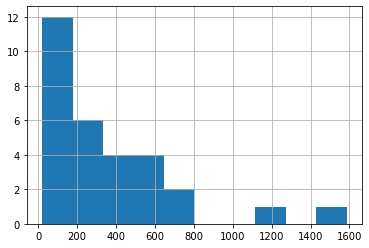

In [10]:
pra_df['vol'].hist()